# Density Map Generation for Crowd Counting

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from glob import glob
import scipy
from scipy.ndimage import gaussian_filter
from scipy.io import loadmat
from IPython.display import clear_output
import cv2     # for capturing videos

## Density Maps Generation

#### Import Image and GT

In [15]:
## Paths of sample image and GT (GT is a .mat file containing head annottaions of the given image)
img_path = 'G:/My Drive/PDRA/works/cc_datasets/ShanghaiTechPartB/train_data/images/IMG_245.jpg'
gt_path  = 'G:/My Drive/PDRA/works/cc_datasets/ShanghaiTechPartB/train_data/ground-truth/GT_IMG_245.mat'


### Fixed Kernel

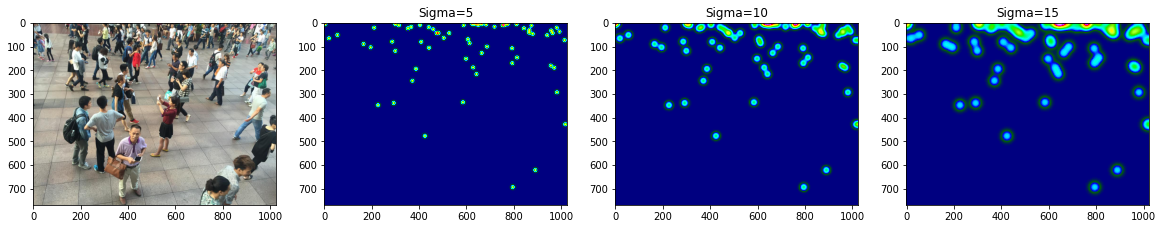

In [16]:

def fixed_density_map(img_path, gt_path, sigma):
    img   = cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB)
    img   = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) # float32 [0,1]
    mat   = loadmat(gt_path)
    pos   = mat.get("image_info")[0][0][0][0][0]
    z     = np.zeros((img.shape[0], img.shape[1]), dtype=np.float32)  

    for i, j in pos:
        z[int(j), int(i)] = 1 # Transformation of coordinates
    
    sigma = sigma
    dm = gaussian_filter(z, sigma)
    return dm


# Generate DMAPs
dm1 = fixed_density_map(img_path, gt_path, sigma=5)
dm2 = fixed_density_map(img_path, gt_path, sigma=10)
dm3 = fixed_density_map(img_path, gt_path, sigma=15)

fig, axes = plt.subplots(1,4, figsize=(20,4))
axes[0].imshow(plt.imread(img_path))
axes[1].imshow(dm1, cmap='gist_ncar') #tab10, tab20c, gist_ncar, jet, turbo, terrain 
axes[2].imshow(dm2, cmap='gist_ncar') #tab10, tab20c, gist_ncar, jet, turbo, terrain 
axes[3].imshow(dm3, cmap='gist_ncar') #tab10, tab20c, gist_ncar, jet, turbo, terrain 
axes[1].set_title('Sigma=5')
axes[2].set_title('Sigma=10')
axes[3].set_title('Sigma=15')
plt.savefig('fixed_kernel_dmaps.png', dpi=300)

### Geometry-adaptive kernel

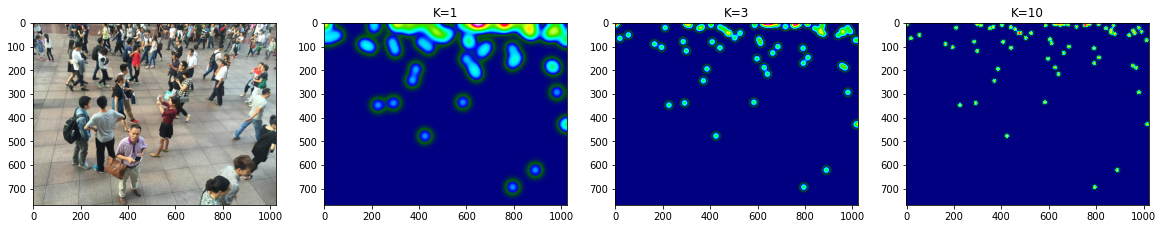

In [17]:

# @jit #(nopython=True, parallel=True)
def adaptive_density_map(img_path, gt_path, k):
    img = cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB)
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) # float32 [0,1]
    mat   = loadmat(gt_path)
    pos   = mat.get("image_info")[0][0][0][0][0]
    z    = np.zeros((img.shape[0], img.shape[1]), dtype=np.float32)
    dm   = np.zeros((img.shape[0], img.shape[1]), dtype=np.float32)  
    
    tree = scipy.spatial.KDTree(pos, leafsize=2)   # from sklearn.neighbors import KDTree, leaf_size measures speed
    dist, ind = tree.query(pos, k=k+1)   # Distance to k+1 closest poinst (first point is self)
    
    for i, j in pos:
        z[int(j), int(i)] = 1 # Transformation of coordinates
        
    for i in range( len(pos) ):
        sigma = np.mean(dist[i, 1:(k+1)]) / k # average of three distances
        sigma = sigma / 2 # half of average distance to k neighbors
        # dm += gaussian_filter(z, sigma=sigma, truncate=10) # truncate=10 is the Maximum sigma not to exceed e.g., 10
    dm = gaussian_filter(z, sigma=sigma) # Which one is correct? above inside for loop or outside as this line?
        
    return dm



###########   Generate DMAPs
dm1 = adaptive_density_map(img_path, gt_path, k=1)
dm2 = adaptive_density_map(img_path, gt_path, k=3)
dm3 = adaptive_density_map(img_path, gt_path, k=10)

fig, axes = plt.subplots(1,4, figsize=(20,4))
axes[0].imshow(plt.imread(img_path))
axes[1].imshow(dm1, cmap='gist_ncar') #tab10, tab20c, gist_ncar, jet, turbo, terrain 
axes[2].imshow(dm2, cmap='gist_ncar') #tab10, tab20c, gist_ncar, jet, turbo, terrain 
axes[3].imshow(dm3, cmap='gist_ncar') #tab10, tab20c, gist_ncar, jet, turbo, terrain 
axes[1].set_title('K=1')
axes[2].set_title('K=3')
axes[3].set_title('K=10')
plt.savefig('geometry_adaptive_dmaps.png', dpi=300)


~  Thank you

Author: M. A. Khan (Email: asifk@ieee.org)